# Setup

In [1]:
pip install -r ../../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
# Add directory above current directory to path
import sys

sys.path.insert(0, '../..')

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from utils.text_processing import CharTokenizer

In [6]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.get_memory_info("GPU:0")

2023-06-14 12:30:48.203419: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 12:30:48.716417: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-14 12:30:48.716479: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30967 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3a:00.0, compute capability: 7.0


In [7]:
config = json.load(open("./configs/mnn_em_w2v_pretrained_amazon.json"))

# Loading data

In [8]:
from data_loader.abo import ABO

In [9]:
data = ABO(path=config["data"]["path"],
           download=False,
           extract=False,
           preprocess=True,
           alt_augment=False,
           random_deletion=False,
           export_csv=True).data

# data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
# data = data.drop({"Unnamed: 0"}, axis=1)

data = data[['description', 'path', 'product_type', 'label']]
# data = data.sample(10000)
data

Loading images...
Loading texts...
Importing listings CSV...
Creating false samples/complement...
Merging ground truth and complement...
Concatenating attributes into description columns...
Finishing up...
Exporting to CSV...
Data processing complete


,description,path,product_type,label
0,surface cleanerb07zkpz5m9amazon brand - presto...,11/11fcff6f.jpg,HEALTH_PERSONAL_CARE,1
1,mobile coverb07tcwt6qzamazon brand - solimo de...,6d/6d467c22.jpg,CELLULAR_PHONE_CASE,1
2,clear caseb08569tz7mamazon brand rivet geomet...,ae/ae7772de.jpg,GROCERY,0
3,grocery & gourmet food beverages bottled bever...,97/97abbdae.jpg,JUICE_AND_JUICE_DRINK,1
4,back coverb08569h3s9amazon brand - solimo desi...,18/18096140.jpg,CELLULAR_PHONE_CASE,1
...,...,...,...,...
168180,mobile coverb08569ppwramazonbasics metal monit...,17/17f2fb25.jpg,SHOES,0
168181,not applicableb07wny6fhfamazon essentials wome...,db/db20fd35.jpg,SHOES,1
168182,mobile coverb07th14222strathwood chaise lounge...,6d/6dc131cd.jpg,CELLULAR_PHONE_CASE,0
168183,stuffingb07jlz7qc7amazon brand rivet contempo...,ac/acec2689.jpg,PILLOW,1


In [10]:
img = data[["path"]]  # two brackets for keeping the column name
text = data["description"]
product_types = data[["product_type"]]
labels = data[["label"]]

# Text processing

https://huggingface.co/fse/word2vec-google-news-300

Pre-trained vectors trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. The phrases were obtained using a simple data-driven approach described in 'Distributed Representations of Words and Phrases and their Compositionality' 

In [11]:
from gensim.models import KeyedVectors

In [12]:
w2v_pretrained_model = KeyedVectors.load(f'./word2vec-google-news-300/word2vec-google-news-300.model')

In [13]:
w2v_vectors = np.load(f'./word2vec-google-news-300/word2vec-google-news-300.model.vectors.npy', allow_pickle=True)

In [14]:
w2v_vectors.shape

(3000000, 300)

In [15]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=None, output_sequence_length=300)

vectorizer.adapt(text)

In [16]:
text = vectorizer(text).numpy()
text.shape

(168185, 300)

In [17]:
voc = vectorizer.get_vocabulary()
voc[:10]

['',
 '[UNK]',
 'mobile',
 'back',
 'brand',
 'for',
 'solimo',
 'cover',
 'case',
 'designer']

In [18]:
word_index = dict(zip(voc, range(len(voc))))

In [19]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    if w2v_pretrained_model.has_index_for(word):
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = w2v_pretrained_model.get_vector(word, norm=True)
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 8977 words (155200 misses)


W2V Google Embedding only converts less than 10% of data!

# Image processing

In [20]:
from utils.img_processing import load_img_model, create_embeddings_from

In [21]:
img_model = load_img_model(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [22]:
%%time
# Mobilenetv3small:
# batch_size = 1024 -> 8 GB VRAM
# batch_size = 2048 -> 16 GB VRAM
# ...
# Mobilenetv3large: twice as much as Mobilenetv3small

img = create_embeddings_from(img_model,
                             img,
                             os.path.join(config["data"]["path"],
                                          "images/small"),
                             batch_size=4096)

Found 168185 validated image filenames.


2023-06-14 12:32:40.396612: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8700
2023-06-14 12:32:47.937273: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


CPU times: user 4min 18s, sys: 2min 50s, total: 7min 9s
Wall time: 23min 1s


In [23]:
img.shape

(168185, 576)

# Save embeddings

In [24]:
save_path = os.path.join(config["data"]["path"],
                         f"embeddings/w2v_pretrained/{img_model.name}")

In [25]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img.npy", img)
np.save(f"{save_path}/text.npy", text)
data.to_csv(f"{save_path}/data.csv")

## Verify import

In [26]:
data = pd.read_csv(f"{save_path}/data.csv")
data = data.drop({"Unnamed: 0"}, axis=1)
data

,description,path,product_type,label
0,surface cleanerb07zkpz5m9amazon brand - presto...,11/11fcff6f.jpg,HEALTH_PERSONAL_CARE,1
1,mobile coverb07tcwt6qzamazon brand - solimo de...,6d/6d467c22.jpg,CELLULAR_PHONE_CASE,1
2,clear caseb08569tz7mamazon brand rivet geomet...,ae/ae7772de.jpg,GROCERY,0
3,grocery & gourmet food beverages bottled bever...,97/97abbdae.jpg,JUICE_AND_JUICE_DRINK,1
4,back coverb08569h3s9amazon brand - solimo desi...,18/18096140.jpg,CELLULAR_PHONE_CASE,1
...,...,...,...,...
168180,mobile coverb08569ppwramazonbasics metal monit...,17/17f2fb25.jpg,SHOES,0
168181,not applicableb07wny6fhfamazon essentials wome...,db/db20fd35.jpg,SHOES,1
168182,mobile coverb07th14222strathwood chaise lounge...,6d/6dc131cd.jpg,CELLULAR_PHONE_CASE,0
168183,stuffingb07jlz7qc7amazon brand rivet contempo...,ac/acec2689.jpg,PILLOW,1


In [27]:
img = np.load(f"{save_path}/img.npy", allow_pickle=True)
img.shape

(168185, 576)

In [28]:
text = np.load(f"{save_path}/text.npy", allow_pickle=True)
text.shape

(168185, 300)

# Train-Test Split

To use `stratify` parameter of `sklearn.model_selection.train_test_split()`, we need to select all product instances which appear more than once

In [29]:
data["product_type_count"] = data.groupby(
    ["product_type"])["product_type"].transform("count")

data = data[data["product_type_count"] > config["data"]["cls"]]

In [30]:
# Update both columns
product_types = data[["product_type"]]

labels = data[["label"]]

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
train, test, labels_train, labels_test = train_test_split(
    data,
    labels,
    stratify=product_types,
    test_size=config["model"]["training"]["test_split"],
    random_state=42)

In [33]:
img_train = img[train.index]
img_test = img[test.index]

text_train = text[train.index]
text_test = text[test.index]

# Save Char CNN config

Not needed, as we use GloVe for text embeddings instead

In [34]:
# from models.char_cnn_zhang import CharCNNZhang

In [35]:
# char_cnn_config = {
#     "input_size": config["data"]["input_size"],
#     "embedding_size": len(tk.word_index),
#     "conv_layers": config["char_cnn_zhang"]["conv_layers"],
#     "fc_layers": config["char_cnn_zhang"]["fc_layers"],
#     "output_size": config["char_cnn_zhang"]["output_size"],
#     "embedding_weights": weights
# }

In [36]:
# char_cnn = CharCNNZhang(**char_cnn_config)

# Build MNN-EM Model

![](../../assets/images/MNN_EM.png)

In [37]:
# from models.mnn_em import MNNEM
from utils.metrics import create_metrics

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Multiply, BatchNormalization, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, BinaryAccuracy, CosineSimilarity


class MNNEMWord2VecPretrained(object):
    def __init__(
            self, head_config, combined_fc_layers, learning_rate,
            metrics=["recall", "precision", "binary_accuracy", "cosine_similarity"],
            loss='binary_crossentropy', name="MNN_EM") -> None:
        self.head_config = head_config
        self.combined_fc_layers = combined_fc_layers
        self.learning_rate = learning_rate
        self.metrics = metrics
        self.loss = loss
        self.name = name
        self._build_model()  # builds self.model variable

    def _build_model(self):
        # Input Layer
        img_features = Input(
            shape=(self.head_config["img_input_size"]), name="Image_Input")

        # Input Layer
        text_features = Input(
            shape=(self.head_config["txt_input_size"]), dtype=tf.int64, name="Text_Input")

        x = _MNNEMHead(**self.head_config)

        x = x.model([img_features, text_features])

        # FC Layers
        for i, comb_fl in enumerate(self.combined_fc_layers, 1):
            x = Dense(comb_fl, activation='relu',
                      name=f"Combined_FC_{i}")(x)

        output = Dense(1, activation='sigmoid', name="Sigmoid")(x)
        model = Model(inputs=[img_features, text_features],
                      outputs=output, name=self.name)

        optimizer = Adam(learning_rate=self.learning_rate)

        model.compile(optimizer=optimizer, loss=self.loss,
                      metrics=self.metrics)
        self.model = model
        # print("MNN-EM model built: ")
        # self.model.summary()


class _MNNEMHead(object):
    def __init__(self, img_input_size, txt_input_size, img_fc_layers,
                 txt_fc_layers, extended):
        self.img_input_size = img_input_size
        self.txt_input_size = txt_input_size
        self.img_fc_layers = img_fc_layers
        self.txt_fc_layers = txt_fc_layers
        self.extended = extended
        self._build_model()  # builds self.model variable

    def _build_model(self):
        # Text Input
        img_features = Input(shape=(self.img_input_size),
                             name="Image_Input_Head_Outer")

        img_cnn = _CNNBranch(self.img_input_size,
                             self.img_fc_layers, self.extended, name="Image")

        output_img = img_cnn.model(img_features)

        # Image Input
        text_features = Input(shape=(self.txt_input_size), dtype=tf.int64, name="Text_Input_Head_Outer")

        embedding_layer = Embedding(
            num_tokens,
            self.txt_input_size,
            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
            trainable=False,
        )

        x = embedding_layer(text_features)

        x = Flatten()(x)

        text_cnn = _CNNBranch(x.shape[1],
                             self.txt_fc_layers, self.extended, name="Text")

        output_text = text_cnn.model(x)

        # Element-wise product
        combined = Multiply(
            name="Element-wise_Multiplication")([output_img, output_text])

        model = Model(inputs=[img_features, text_features],
                      outputs=combined, name="MNN_EM_Head")

        self.model = model


class _CNNBranch(object):
    def __init__(self, input_size, fc_layers, extended, name):
        self.input_size = input_size
        self.fc_layers = fc_layers
        self.extended = extended
        self.name = name
        self._build_model()  # builds self.model variable

    def _build_model(self):
        # Input Layer
        features = Input(shape=(self.input_size),
                         name=f"{self.name}_Input_Head_Inner")

        # fc + ReLU
        for i, fl in enumerate(
                self.fc_layers[: None if self.extended else -1],
                1):
            x = Dense(fl, activation='relu',
                      name=f"{self.name}_FC_{i}")(features if i == 1 else x)

        if not self.extended:
            # fc + L2 Norm
            x = Dense(
                self.fc_layers[-1],
                kernel_regularizer='l2', name=f"{self.name}_FC_last")(
                features if len(self.fc_layers) == 1 else x)

        output = BatchNormalization(name=f"{self.name}_Batch_Normalization")(x)

        model = Model(inputs=features, outputs=output, name=f"{self.name}_CNN")

        self.model = model

In [39]:
head_config = {
    "img_input_size": img_model.layers[-1].output_shape[1],
    "txt_input_size": embedding_dim,
    "img_fc_layers": config["model"]["img_fc_layers"],
    "txt_fc_layers": config["model"]["txt_fc_layers"],
    "extended": False,
}

In [40]:
mnn_em = MNNEMWord2VecPretrained(head_config=head_config,
               combined_fc_layers=config["model"]["combined_fc_layers"],
               learning_rate=config["model"]["training"]["learning_rate"],
               metrics=create_metrics(config["model"]["training"]["metrics"]))

In [41]:
mnn_em.model.summary(expand_nested=True)

Model: "MNN_EM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 576)]        0           []                               
                                                                                                  
 Text_Input (InputLayer)        [(None, 300)]        0           []                               
                                                                                                  
 MNN_EM_Head (Functional)       (None, 512)          143059268   ['Image_Input[0][0]',            
                                                                  'Text_Input[0][0]']             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Text_Input_Head_Outer (InputLa  [(None, 300)]     0           []                           

In [42]:
# "Head"

tf.keras.utils.plot_model(mnn_em.model.layers[2],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [43]:
# Image CNN

tf.keras.utils.plot_model(mnn_em.model.layers[2].layers[4],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [44]:
# Full model

tf.keras.utils.plot_model(mnn_em.model,
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# Callbacks

In [45]:
from utils.metrics import create_callbacks

In [46]:
log_dir = config["model"]["training"]["log_dir"]
model_name = config["model"]["name"]
optimizer_name = config["model"]["training"]["optimizer"]
learning_rate = config["model"]["training"]["learning_rate"]

In [47]:
callbacks = create_callbacks(
    callbacks_list=config["model"]["training"]["callbacks"],
    log_dir=log_dir,
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    cls=config["data"]["cls"])

# Training

In [48]:
history = mnn_em.model.fit(
    x=[img_train, text_train],
    y=labels_train,
    epochs=config["model"]["training"]["epochs"],
    validation_split=config["model"]["training"]["validation_split"],
    batch_size=config["model"]["training"]["batch_size"],
    callbacks=callbacks)

Epoch 1/10
8513/8513 [==============================] - ETA: 0s - loss: 1.3783 - recall: 0.9246 - precision: 0.8793 - binary_accuracy: 0.8949 - cosine_similarity: 0.5196

2023-06-14 12:56:06.075420: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


8513/8513 [==============================] - 157s 18ms/step - loss: 1.3783 - recall: 0.9246 - precision: 0.8793 - binary_accuracy: 0.8949 - cosine_similarity: 0.5196 - val_loss: 0.2925 - val_recall: 0.9497 - val_precision: 0.9328 - val_binary_accuracy: 0.9382 - val_cosine_similarity: 0.5202
Epoch 2/10
8513/8513 [==============================] - ETA: 0s - loss: 0.2358 - recall: 0.9657 - precision: 0.9394 - binary_accuracy: 0.9498 - cosine_similarity: 0.5196

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


8513/8513 [==============================] - 158s 19ms/step - loss: 0.2358 - recall: 0.9657 - precision: 0.9394 - binary_accuracy: 0.9498 - cosine_similarity: 0.5196 - val_loss: 0.2287 - val_recall: 0.9602 - val_precision: 0.9472 - val_binary_accuracy: 0.9515 - val_cosine_similarity: 0.5202
Epoch 3/10
8513/8513 [==============================] - ETA: 0s - loss: 0.1854 - recall: 0.9750 - precision: 0.9552 - binary_accuracy: 0.9633 - cosine_similarity: 0.5196

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


8513/8513 [==============================] - 158s 19ms/step - loss: 0.1854 - recall: 0.9750 - precision: 0.9552 - binary_accuracy: 0.9633 - cosine_similarity: 0.5196 - val_loss: 0.1934 - val_recall: 0.9721 - val_precision: 0.9561 - val_binary_accuracy: 0.9623 - val_cosine_similarity: 0.5202
Epoch 4/10
8513/8513 [==============================] - ETA: 0s - loss: 0.1577 - recall: 0.9794 - precision: 0.9656 - binary_accuracy: 0.9711 - cosine_similarity: 0.5196

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


8513/8513 [==============================] - 158s 19ms/step - loss: 0.1577 - recall: 0.9794 - precision: 0.9656 - binary_accuracy: 0.9711 - cosine_similarity: 0.5196 - val_loss: 0.1867 - val_recall: 0.9726 - val_precision: 0.9601 - val_binary_accuracy: 0.9647 - val_cosine_similarity: 0.5202
Epoch 5/10
8513/8513 [==============================] - ETA: 0s - loss: 0.1373 - recall: 0.9827 - precision: 0.9716 - binary_accuracy: 0.9761 - cosine_similarity: 0.5196

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


8513/8513 [==============================] - 159s 19ms/step - loss: 0.1373 - recall: 0.9827 - precision: 0.9716 - binary_accuracy: 0.9761 - cosine_similarity: 0.5196 - val_loss: 0.1830 - val_recall: 0.9685 - val_precision: 0.9619 - val_binary_accuracy: 0.9637 - val_cosine_similarity: 0.5202
Epoch 6/10
8513/8513 [==============================] - ETA: 0s - loss: 0.1232 - recall: 0.9849 - precision: 0.9760 - binary_accuracy: 0.9796 - cosine_similarity: 0.5196

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


8513/8513 [==============================] - 157s 18ms/step - loss: 0.1232 - recall: 0.9849 - precision: 0.9760 - binary_accuracy: 0.9796 - cosine_similarity: 0.5196 - val_loss: 0.1736 - val_recall: 0.9789 - val_precision: 0.9606 - val_binary_accuracy: 0.9682 - val_cosine_similarity: 0.5200
Epoch 7/10
8513/8513 [==============================] - ETA: 0s - loss: 0.1122 - recall: 0.9865 - precision: 0.9789 - binary_accuracy: 0.9819 - cosine_similarity: 0.5196

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


8513/8513 [==============================] - 157s 18ms/step - loss: 0.1122 - recall: 0.9865 - precision: 0.9789 - binary_accuracy: 0.9819 - cosine_similarity: 0.5196 - val_loss: 0.1640 - val_recall: 0.9879 - val_precision: 0.9533 - val_binary_accuracy: 0.9685 - val_cosine_similarity: 0.5202
Epoch 8/10
8513/8513 [==============================] - ETA: 0s - loss: 0.1015 - recall: 0.9878 - precision: 0.9821 - binary_accuracy: 0.9843 - cosine_similarity: 0.5196

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


8513/8513 [==============================] - 159s 19ms/step - loss: 0.1015 - recall: 0.9878 - precision: 0.9821 - binary_accuracy: 0.9843 - cosine_similarity: 0.5196 - val_loss: 0.1539 - val_recall: 0.9842 - val_precision: 0.9645 - val_binary_accuracy: 0.9730 - val_cosine_similarity: 0.5202
Epoch 9/10
8513/8513 [==============================] - 66s 8ms/step - loss: 0.0957 - recall: 0.9888 - precision: 0.9831 - binary_accuracy: 0.9853 - cosine_similarity: 0.5196 - val_loss: 0.1609 - val_recall: 0.9816 - val_precision: 0.9625 - val_binary_accuracy: 0.9705 - val_cosine_similarity: 0.5202
Epoch 10/10
8513/8513 [==============================] - 66s 8ms/step - loss: 0.0888 - recall: 0.9899 - precision: 0.9846 - binary_accuracy: 0.9867 - cosine_similarity: 0.5196 - val_loss: 0.1671 - val_recall: 0.9869 - val_precision: 0.9531 - val_binary_accuracy: 0.9680 - val_cosine_similarity: 0.5202


# Evaluation

## Plot loss and metrics

In [49]:
from utils.metrics import plot_metrics

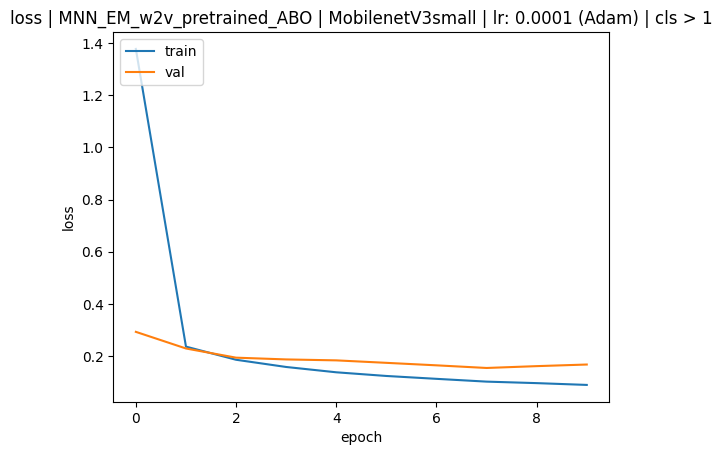

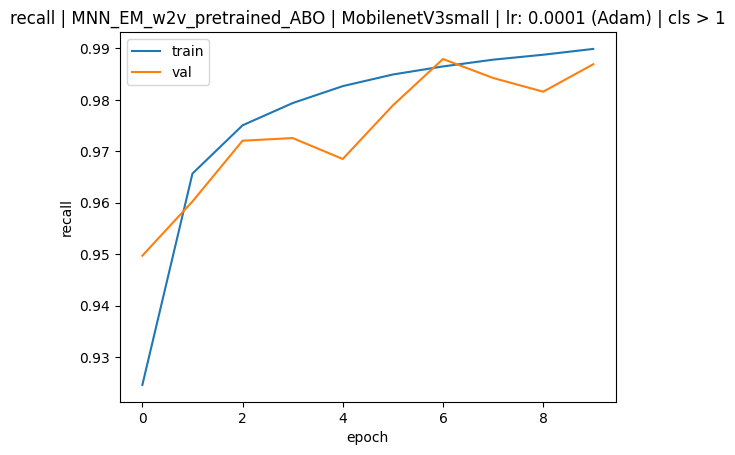

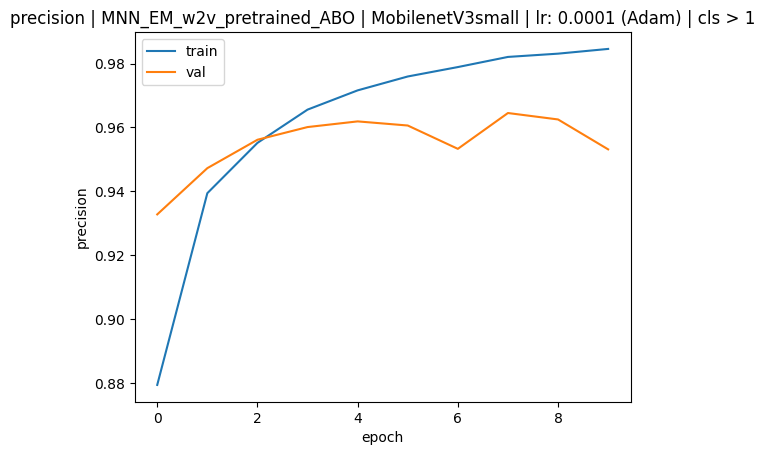

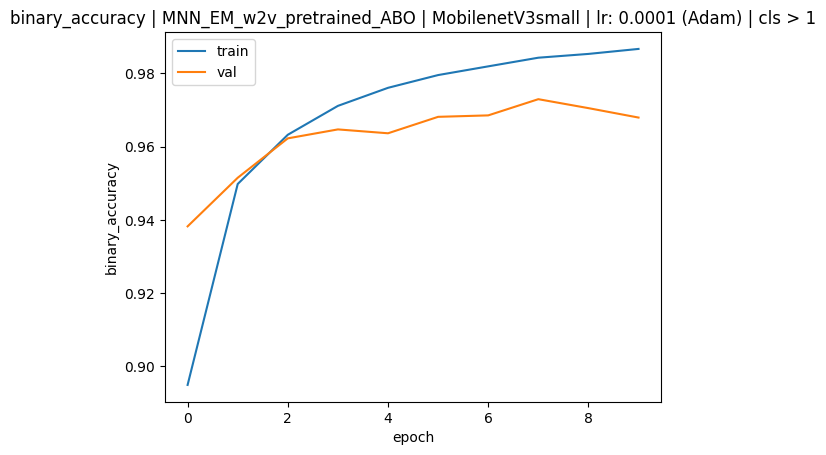

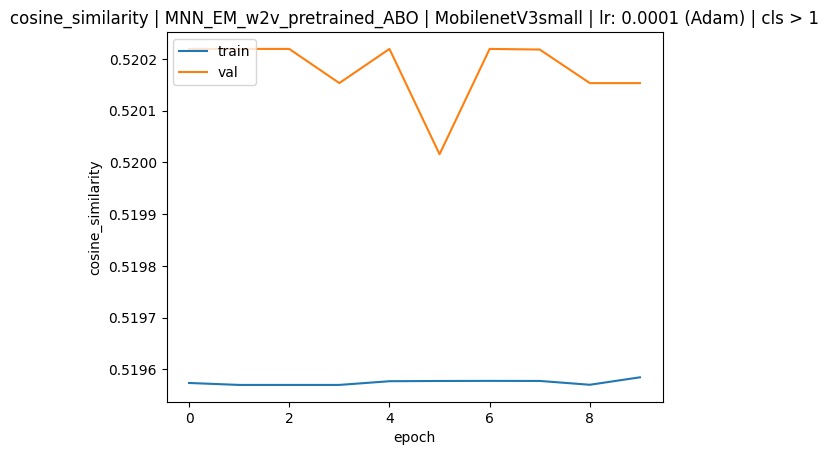

In [50]:
plot_metrics(history.history, config["model"]["training"]["metrics"],
             model_name, img_model.name, optimizer_name, learning_rate,
             config["data"]["cls"])

## Evaluate model and save metrics

In [51]:
from utils.metrics import evaluate

In [52]:
evaluate(mnn_em.model, [img_test, text_test], labels_test, log_dir, model_name,
         img_model.name, optimizer_name, learning_rate, config["data"]["cls"])

16816/16816 [==============================] - 39s 2ms/step - loss: 0.1589 - recall: 0.9881 - precision: 0.9585 - binary_accuracy: 0.9716 - cosine_similarity: 0.5187
